# Dataset Creation and Transformation

In this vignette, we showcase a typical analysis workflow for cytometry data. First, we will assemble necessary metadata, the panel information and the accompanying workspace from FlowJo.

In order to transform the data, we will use the automated calculation of the necessary cofactors. Cofactors are the values that separate the positive from the negative populations in a specific channel. These values are used for the transformation itself as well as for the calculation of frequency-positives (FOP). 

We start by importing the necessary libraries.

In [1]:
import warnings
warnings.filterwarnings(
    action='ignore',
    category=FutureWarning
)

In [2]:
import FACSPy as fp

## Assemble the supplementary data

We read the metadata table directly as a Metadata object. For further information how to use this object, e.g. in order to change values or add columns, please refer to the respective vignette.

The panel information is similarly read into a Panel object.

Lastly, the FlowJoWorkspace is imported which contains the compensation matrix as well as the gating we set manually.

In [3]:
panel = fp.dt.Panel("../../Tutorials/mouse_lineages/panel.csv")
metadata = fp.dt.Metadata("../../Tutorials/mouse_lineages/metadata_bm.csv")
workspace = fp.dt.FlowJoWorkspace("../../Tutorials/mouse_lineages/lineages_full_gated_bm.wsp")

Finally, we create the dataset.

In [4]:
dataset = fp.create_dataset(input_directory = "../../Tutorials/mouse_lineages",
                            panel = panel,
                            metadata = metadata,
                            workspace = workspace)

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\FACSPy\exceptions\_exceptions.py:40: UserWarning: Some data points exceed the PnR value. The data points are truncated. To avoid truncation, set the PnR value manually or pass `truncate_max_range = False`. The following counts were outside the channel range: FSC-A: 4046, FSC-H: 39, FSC-W: 112, SSC-A: 699, SSC-H: 20, SSC-W: 39, BUV496-A: 4, BB700-A: 9
  warnings.warn(self.message, UserWarning)
C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\FACSPy\exceptions\_exceptions.py:40: UserWarning: Some data points exceed the PnR value. The data points are truncated. To avoid truncation, set the PnR value manually or pass `truncate_max_range = False`. The following counts were outside the channel range: FSC-A: 3756, FSC-H: 49, FSC-W: 115, SSC-A: 801, SSC-H: 25, SSC-W: 51, GFP-A: 2, APC-A: 1, APC-H7-A: 1, BV421-A: 5, BV510-A: 13, BV605-A: 6, BB700-A: 1
  warnings.warn(self.message, UserWarning)
C:\Users\tarik\anaconda3\envs

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\FACSPy\exceptions\_exceptions.py:40: UserWarning: Some data points exceed the PnR value. The data points are truncated. To avoid truncation, set the PnR value manually or pass `truncate_max_range = False`. The following counts were outside the channel range: FSC-A: 4807, FSC-H: 66, FSC-W: 220, SSC-A: 872, SSC-H: 15, SSC-W: 98, GFP-A: 1, BV605-A: 7, BUV395-A: 20, BUV496-A: 4
  warnings.warn(self.message, UserWarning)
C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\FACSPy\exceptions\_exceptions.py:40: UserWarning: Some data points exceed the PnR value. The data points are truncated. To avoid truncation, set the PnR value manually or pass `truncate_max_range = False`. The following counts were outside the channel range: FSC-A: 3448, FSC-H: 54, FSC-W: 127, SSC-A: 831, SSC-H: 14, SSC-W: 59, GFP-A: 1, APC-A: 24, APC-H7-A: 37, BV421-A: 1920, BV510-A: 6340, BV605-A: 557, BV711-A: 51, BV786-A: 42, BUV395-A: 131, BUV496-A:

... gating sample 20112023_lineage_BM_Cre_neg_unstained_037.fcs
... gating sample 20112023_lineage_BM_Cre_pos_unstained_036.fcs
... gating sample 20112023_lineage_BM_M1_038.fcs
... gating sample 20112023_lineage_BM_M2_039.fcs
... gating sample 20112023_lineage_BM_M3_040.fcs
... gating sample 20112023_lineage_BM_M4_041.fcs
... gating sample 20112023_lineage_BM_M5_042.fcs
... gating sample 20112023_lineage_BM_M6_043.fcs
... gating sample 21112023_lineage_BM_Cre_neg_unstained_010.fcs
... gating sample 21112023_lineage_BM_Cre_pos_unstained_009.fcs
... gating sample 21112023_lineage_BM_M10_014.fcs
... gating sample 21112023_lineage_BM_M11_015.fcs
... gating sample 21112023_lineage_BM_M12_016.fcs
... gating sample 21112023_lineage_BM_M7_011.fcs
... gating sample 21112023_lineage_BM_M8_012.fcs
... gating sample 21112023_lineage_BM_M9_013.fcs
... gating sample 22112023_lineage_BM_Cre_neg_unstained_010.fcs
... gating sample 22112023_lineage_BM_Cre_pos_unstained_009.fcs
... gating sample 2211202

We obtain a dataset consisting of 3.212.862 cells of 20 channels.

For the specifics on how a AnnData object is built, please refer to the vignette "The FACSPy dataset".

In [5]:
dataset

AnnData object with n_obs × n_vars = 3212862 × 20
    obs: 'sample_ID', 'file_name', 'organ', 'genotype', 'sex', 'experiment', 'age'
    var: 'pns', 'png', 'pne', 'pnr', 'type', 'pnn'
    uns: 'metadata', 'panel', 'workspace', 'gating_cols', 'dataset_status_hash'
    obsm: 'gating'
    layers: 'compensated'

## Prepare cofactor calculation

In order to perform the cofactor calculation, we need to specify which samples are stained. We do this by creating a column called 'staining' in the metadata. 

If there are no control samples, mark every file as stained.

Of course, this column can already be specified using Excel.

In [6]:
metadata_frame = dataset.uns["metadata"].to_df()
stained_files = [file for file in metadata_frame["file_name"] if not "unstained" in file]
unstained_files = [file for file in metadata_frame["file_name"] if "unstained" in file]

metadata = dataset.uns["metadata"]
metadata.annotate(file_names = stained_files, column = "staining", value = "stained")
metadata.annotate(file_names = unstained_files, column = "staining", value = "unstained")

metadata_frame = dataset.uns["metadata"].to_df()
metadata_frame.head()

,sample_ID,file_name,organ,genotype,sex,experiment,age,staining
0,1,20112023_lineage_BM_Cre_neg_unstained_037.fcs,BM,neg,m,1,95,unstained
1,2,20112023_lineage_BM_Cre_pos_unstained_036.fcs,BM,pos,m,1,95,unstained
2,3,20112023_lineage_BM_M1_038.fcs,BM,pos,f,1,95,stained
3,4,20112023_lineage_BM_M2_039.fcs,BM,neg,f,1,95,stained
4,5,20112023_lineage_BM_M3_040.fcs,BM,pos,f,1,95,stained


FACSPy implements a synchronization module in order to transfer metadata to the .obs slot and vice versa. Here, we use the synchronization to transfer the respective staining information to the .obs slot.

For further information about synchronization of supplementary files in FACSPy, please refer to the respective vignette.

In [7]:
fp.sync.synchronize_dataset(dataset)
dataset.obs.head()

Found modified subsets: ['metadata_columns']
	... synchronizing dataset to contain columns of the metadata object


C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\FACSPy\exceptions\_exceptions.py:12: UserWarning: It was detected that the dataset was modified.Please make sure that the performed analyses are still valid. Note that if you removed whole samples, mfi/fop calculations will not be affected.
  warnings.warn(message, UserWarning)
C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\FACSPy\synchronization\_synchronize.py:106: DataModificationWarning: 'It was detected that the dataset was modified.Please make sure that the performed analyses are still valid. Note that if you removed whole samples, mfi/fop calculations will not be affected.'
  warnings.warn('', DataModificationWarning)


,staining,sample_ID,file_name,organ,genotype,sex,experiment,age
OBS_INDEX,,,,,,,,
0-0,unstained,1,20112023_lineage_BM_Cre_neg_unstained_037.fcs,BM,neg,m,1,95
1-0,unstained,1,20112023_lineage_BM_Cre_neg_unstained_037.fcs,BM,neg,m,1,95
2-0,unstained,1,20112023_lineage_BM_Cre_neg_unstained_037.fcs,BM,neg,m,1,95
3-0,unstained,1,20112023_lineage_BM_Cre_neg_unstained_037.fcs,BM,neg,m,1,95
4-0,unstained,1,20112023_lineage_BM_Cre_neg_unstained_037.fcs,BM,neg,m,1,95


## Cofactor calculation

We calculate the cofactors.

In [8]:
fp.dt.calculate_cofactors(dataset)

... calculating cofactors
    ... sample 20112023_lineage_BM_M1_038.fcs
    ... sample 20112023_lineage_BM_M2_039.fcs
    ... sample 20112023_lineage_BM_M3_040.fcs
    ... sample 20112023_lineage_BM_M4_041.fcs
    ... sample 20112023_lineage_BM_M5_042.fcs
    ... sample 20112023_lineage_BM_M6_043.fcs
    ... sample 21112023_lineage_BM_M10_014.fcs
    ... sample 21112023_lineage_BM_M11_015.fcs
    ... sample 21112023_lineage_BM_M12_016.fcs
    ... sample 21112023_lineage_BM_M7_011.fcs
    ... sample 21112023_lineage_BM_M8_012.fcs
    ... sample 21112023_lineage_BM_M9_013.fcs
    ... sample 22112023_lineage_BM_M13_011.fcs
    ... sample 22112023_lineage_BM_M14_012.fcs
    ... sample 22112023_lineage_BM_M15_013.fcs
    ... sample 22112023_lineage_BM_M16_014.fcs
    ... sample 22112023_lineage_BM_M17_015.fcs
    ... sample 22112023_lineage_BM_M18_016.fcs


Note that we have additional entries in the .uns slot, containing the cofactors as a CofactorTable and the raw cofactors per channel.

In [9]:
dataset

AnnData object with n_obs × n_vars = 3212862 × 20
    obs: 'staining', 'sample_ID', 'file_name', 'organ', 'genotype', 'sex', 'experiment', 'age'
    var: 'pns', 'png', 'pne', 'pnr', 'type', 'pnn'
    uns: 'metadata', 'panel', 'workspace', 'gating_cols', 'dataset_status_hash', 'cofactors', 'raw_cofactors'
    obsm: 'gating'
    layers: 'compensated'

In [10]:
dataset.uns["cofactors"].to_df()

,fcs_colname,cofactors
0,GFP,604.558295
1,B220,621.947361
2,CD4,263.386078
3,Siglec-F,5008.094000
4,CD8,17554.892797
5,Ly6C,566.765399
6,NK1.1,140.001241
7,CD11b,495.220923
8,Ly6G,127.525565
9,DAPI,1871.766325


In [11]:
dataset.uns["raw_cofactors"].head()

,GFP,B220,CD4,Siglec-F,CD8,Ly6C,NK1.1,CD11b,Ly6G,DAPI,CD3,F4_80,CD45
20112023_lineage_BM_M1_038.fcs,561.885802,697.288044,274.900653,4616.019368,18617.388921,591.941184,161.576461,551.453101,121.065272,1884.082369,1485.464764,30.352489,829.701150
20112023_lineage_BM_M2_039.fcs,550.521896,1000.362872,375.574566,5223.891111,21314.821039,749.616441,189.394298,652.737863,108.720943,1773.823935,2844.875405,30.505592,771.884750
20112023_lineage_BM_M3_040.fcs,552.284332,744.624092,238.787798,6496.276868,18983.248907,762.533583,233.122450,675.076752,177.245255,1775.922490,1710.166598,30.312181,895.785271
20112023_lineage_BM_M4_041.fcs,825.932949,703.641388,312.354135,6456.971936,13622.016678,522.266000,133.188697,428.974873,156.770022,1803.676715,1453.757090,29.042459,780.603105
20112023_lineage_BM_M5_042.fcs,402.696707,695.864707,338.981557,5022.346330,12743.629672,500.842279,158.653363,460.474069,175.886829,1760.818980,1410.623555,31.184509,745.709945


We can use FACSPy plotting to visualize the results.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


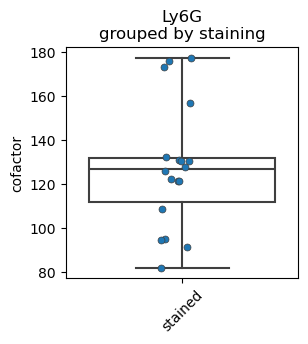

In [12]:
fp.pl.cofactor_distribution(dataset,
                            marker = "Ly6G",
                            groupby = "staining",
                            stat_test = False)

## Transformation

Next, we transform the data using the arcsinh transformation and the newly calculated cofactors. We created a new layer called 'transformed'.

In [13]:
fp.dt.transform(dataset,
                transform = "asinh",
                cofactor_table = dataset.uns["cofactors"],
                key_added = "transformed",
                layer = "compensated")
dataset

AnnData object with n_obs × n_vars = 3212862 × 20
    obs: 'staining', 'sample_ID', 'file_name', 'organ', 'genotype', 'sex', 'experiment', 'age'
    var: 'pns', 'png', 'pne', 'pnr', 'type', 'pnn', 'cofactors'
    uns: 'metadata', 'panel', 'workspace', 'gating_cols', 'dataset_status_hash', 'cofactors', 'raw_cofactors'
    obsm: 'gating'
    layers: 'compensated', 'transformed'

## Transformation visualization

We visualize the transformation result via the transformation plot. Control samples are depicted in blue while the sample of interest (in this case the sample with sample_ID '3') is pictured in red.

The left plot shows the untransformed raw data on a bi-exponential scale.  

The middle plot shows a dot plot with the transformed values. The green line represents the cofactor, specifying the border of negative to positive.

The right plot plots the values as a histogram.  

Note that we have two positive populations of Ly6C, corresponding to Ly6C int Neutrophils and Ly6C hi Monocytes. The cofactor calculation looks very reasonable.

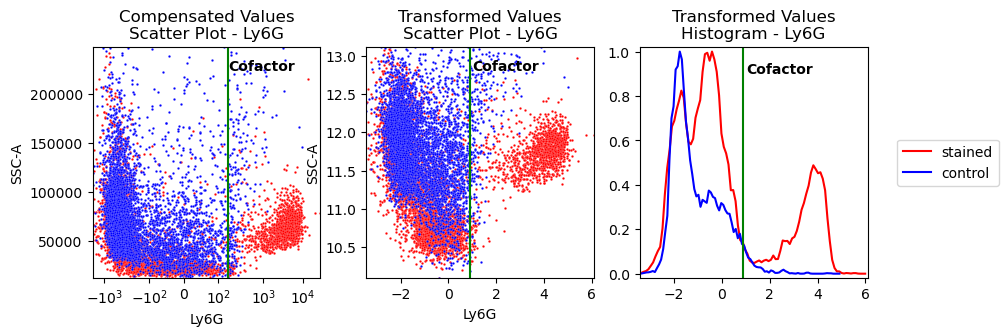

In [14]:
fp.pl.transformation_plot(dataset,
                          gate = "CD45+",
                          sample_identifier = "3",
                          marker = "Ly6G",
                          figsize = (12,3))

## Setting cofactors manually

Note that the cofactor for CD8 was very high.  

Upon closer inspection, we notice a high divergence of the individual samples.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


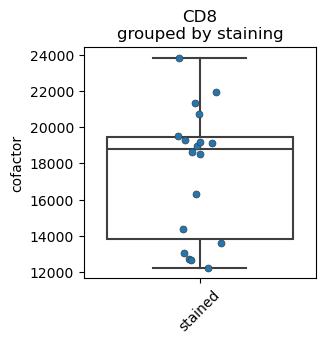

In [15]:
fp.pl.cofactor_distribution(dataset,
                            marker = "CD8",
                            groupby = "staining",
                            stat_test = False)

We notice in the transformation plot, that the cofactor was set too high. We would rather put it at 5000-7000.

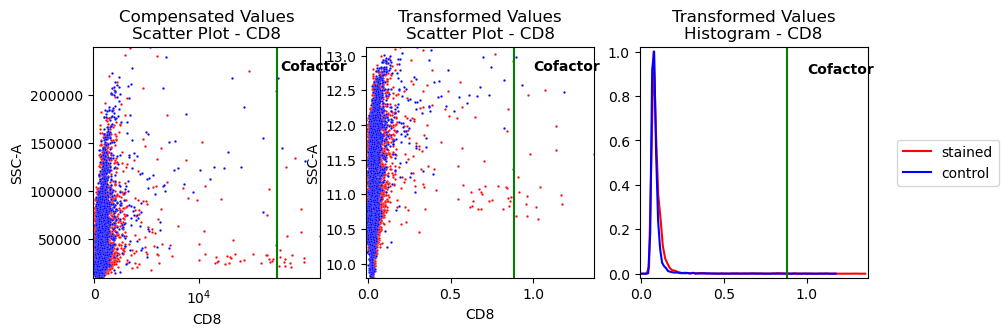

In [16]:
fp.pl.transformation_plot(dataset,
                          gate = "live",
                          sample_identifier = "3",
                          marker = "CD8",
                          figsize = (12,3))

In order to reset the cofactor manually, we use the cofactor table object and retransform the dataset.

In [17]:
dataset.uns["cofactors"].set_cofactor("CD8", 6000)

fp.dt.transform(dataset,
                transform = "asinh",
                cofactor_table = dataset.uns["cofactors"],
                key_added = "transformed")

We visualize the transformation again and observe that the result is much better.

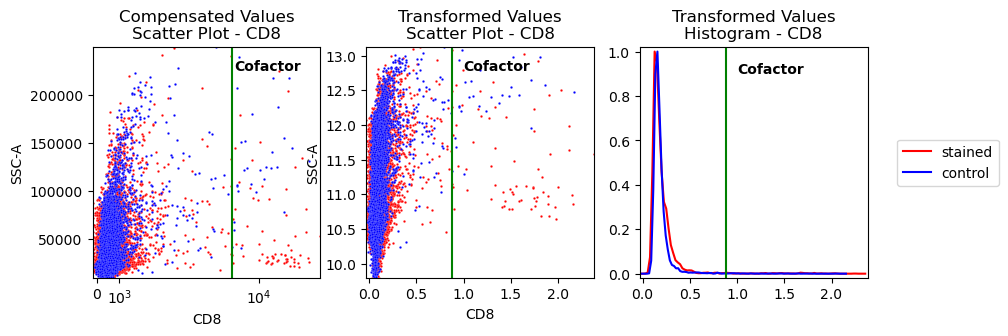

In [18]:
fp.pl.transformation_plot(dataset,
                          gate = "live",
                          sample_identifier = "3",
                          marker = "CD8",
                          figsize = (12,3))

## Other transformation methods

FACSPy implements 'log', 'logicle', 'hyperlog' and 'asinh' transforms.

These can be accessed via the 'transform' parameter in fp.dt.transform(). The 'key_added' parameter controls the name of the corresponding layer...

In [19]:
fp.dt.transform(dataset,
                transform = "logicle",
                key_added = "logicle")
dataset

AnnData object with n_obs × n_vars = 3212862 × 20
    obs: 'staining', 'sample_ID', 'file_name', 'organ', 'genotype', 'sex', 'experiment', 'age'
    var: 'pns', 'png', 'pne', 'pnr', 'type', 'pnn', 'cofactors'
    uns: 'metadata', 'panel', 'workspace', 'gating_cols', 'dataset_status_hash', 'cofactors', 'raw_cofactors'
    obsm: 'gating'
    layers: 'compensated', 'transformed', 'logicle'

... that can be later used for analysis and visualization functions.

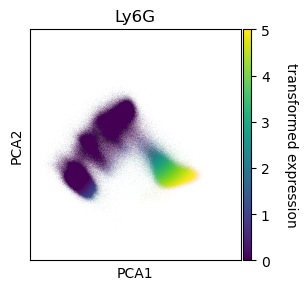

In [20]:
fp.settings.default_gate = "CD45+"

fp.tl.pca(dataset, layer = "transformed")
fp.pl.pca(dataset, layer = "transformed", color = "Ly6G", vmin = 0, vmax = 5)

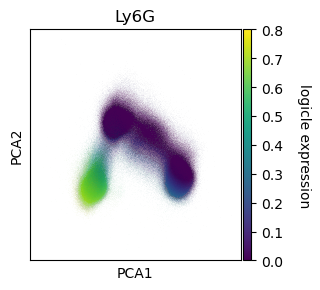

In [21]:
fp.settings.default_gate = "CD45+"

fp.tl.pca(dataset, layer = "logicle")
fp.pl.pca(dataset, layer = "logicle", color = "Ly6G", vmin = 0, vmax = 0.8)

## Save the dataset

Finally, we save the dataset to the hard drive.

In [22]:
fp.save_dataset(dataset,
                output_dir = "../../Tutorials/mouse_lineages",
                file_name = "raw_dataset",
                overwrite = True)

File saved successfully
